### Importing the dependencies

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
#downloading the Amazon Apparel dataset for the recommendation model
!gdown --id 1xWkZ70Fc0y0WvzI-4Iw8fbPI9hP_biZT

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xWkZ70Fc0y0WvzI-4Iw8fbPI9hP_biZT
To: /content/tops_fashion.json
100% 263M/263M [00:04<00:00, 64.7MB/s]


In [3]:
data = pd.read_json('/content/tops_fashion.json')

## Exploratory Data Analysis

In [4]:
df = pd.DataFrame(data)
df = df.drop(['sku', 'author', 'publisher','availability', 'reviews', 'large_image_url','availability_type','small_image_url','editorial_review','model','manufacturer'], axis=1) #dropping the unneccessary columns
df.head()
del data
#asin => amazon standard identification number - simply a unique 10-digit identifier used by amazon to identify products in it's database

In [5]:
#displaying the titles of 10 of the records in the clothing dataset
for i in range(10):
  print(df['title'][i]);
  plt.figure

Minions Como Superheroes Ironman Long Sleeve Round Neck T-Shirt For Women
FIG Clothing Womens Izo Tunic
FIG Clothing Womens Won Top
Focal18 Sailor Collar Bubble Sleeve Blouse Shirt Women Mori Girl Casual Top Harajuku
Featherlite Ladies' Long Sleeve Stain Resistant Tapered Twill Shirt, 2XL, Onyx Black/ Stone
[Fits Cloth] Grape Solid Modern Long Sleeve Plain T Shirt
Women's Unique 100% Cotton T - Special Olympics World Games 2015 White Size L
Floerns Women's Bell Sleeve Beading Casual Blouse Top
Standing on His Promises Rhinestones T-Shirt Ripped Cut Out Red Long
Fila Women's Tulip Durable Tennis Style Comfort Tank


In [6]:
print('Attributes present in the data') #listing down the attributes in the clothing dataset
for col in df.columns:
  print('->',col)

print('\nCount of the Unique values and Null values pertaining to each of the attributes in the dataset')
for col in df.columns:
  print('-> Column: {}, Total values {}, unique values {}, null values {}'.format(col, len(df[col]), len(set(list(df[col]))),sum(df[col].isnull().values)))

Attributes present in the data
-> asin
-> product_type_name
-> formatted_price
-> color
-> brand
-> title
-> medium_image_url
-> editorial_reivew

Count of the Unique values and Null values pertaining to each of the attributes in the dataset
-> Column: asin, Total values 183138, unique values 183138, null values 0
-> Column: product_type_name, Total values 183138, unique values 72, null values 0
-> Column: formatted_price, Total values 183138, unique values 3136, null values 154743
-> Column: color, Total values 183138, unique values 7381, null values 118182
-> Column: brand, Total values 183138, unique values 10578, null values 151
-> Column: title, Total values 183138, unique values 175985, null values 0
-> Column: medium_image_url, Total values 183138, unique values 170782, null values 0
-> Column: editorial_reivew, Total values 183138, unique values 128058, null values 2758


# Basis for Recommendation: Titles of clothes

## Preprocessing Steps
1. Removing products with very few words in it
2. Sorting all the data in increasing alphabetical order of the titles of clothes.
3. Removing titles that are very similar
3. TF-IDF vectorizer has been used to convert the words present in the titles into numerical features. TF-IDF helps us generate numerical features that are descriptive of the actual images of the clothing.

In [7]:
print('Total elements in the clothing list: ', len(df))
print('Attributes of an apparel: ', list(df.columns))
print('Total null elements in formatter_price', sum(df['formatted_price'].isnull().values))

Total elements in the clothing list:  183138
Attributes of an apparel:  ['asin', 'product_type_name', 'formatted_price', 'color', 'brand', 'title', 'medium_image_url', 'editorial_reivew']
Total null elements in formatter_price 154743


In [8]:
df = df.sort_values('title') #sorting the data in increasing alphabetical order of titles
df.reset_index(drop = True, inplace = True)

In [9]:
df.head(10) #shwoing the first 10 entries in the database

,asin,product_type_name,formatted_price,color,brand,title,medium_image_url,editorial_reivew
0,B008D30AGK,SHIRT,$7.51,Multicolored,Out+of+Print+Clothing,"""1984"" Retro Book Cover Women's SLim Fit T-Shi...",https://images-na.ssl-images-amazon.com/images...,
1,B071WD44WX,SHIRT,None,None,Sweet Claire,"""ASAP"" As Southern As Possible Tank Top, Heath...",https://images-na.ssl-images-amazon.com/images...,<p>THIS IS FOR THIS TANK IN HEATHER GREY WITH ...
2,B072M88RQ6,SHIRT,None,None,Sweet Claire,"""ASAP"" As Southern As Possible Tank Top, Off W...",https://images-na.ssl-images-amazon.com/images...,<p>THIS IS FOR THIS TANK IN OFF WHITE WITH BLA...
3,B0739MNWM2,ORCA_SHIRT,None,None,Natural Black Girl T-Shirt,"""Afro Bae"" Beautiful Black Women's Shirt",https://images-na.ssl-images-amazon.com/images...,
4,B01E0XLYHA,SHIRT,None,Blue,GreaterGood,"""Ask Me About My Granddog"" T-Shirt",https://images-na.ssl-images-amazon.com/images...,
5,B01IADM09M,SHIRT,None,None,Acting Pro,"""Baby Bear"" Round Neck Racerback Tank Top",https://images-na.ssl-images-amazon.com/images...,Baby Bear graphic print relaxed fit tank with ...
6,B072J96Z94,SHIRT,None,None,Hoop Culture,"""Basketball Mom"" Women's T-Shirt - Hoop Culture",https://images-na.ssl-images-amazon.com/images...,Mom's represent your child in style with the o...
7,B01I5YLQAA,SHIRT,None,None,Acting Pro,"""Black Is My Happy Color"" Round Neck Tank Top",https://images-na.ssl-images-amazon.com/images...,Black Is My Happy Color graphic print relaxed ...
8,B01IC1F9TK,SHIRT,None,None,Acting Pro,"""Boheme Life"" Scoop Neck Racerback Tank Top",https://images-na.ssl-images-amazon.com/images...,"Graphic print, hip length tank top in a relaxe..."
9,B01I5XOLVM,SHIRT,None,None,Acting Pro,"""But First, Wine"" Round Neck Tank Top",https://images-na.ssl-images-amazon.com/images...,"But First, Wine graphic printed knit muscle ta..."


### **Cleaning the texts**

### Removing duplicates in data

In [10]:
df = df.drop_duplicates(subset = 'medium_image_url').reset_index().drop(['index'],axis=1) #removing entires with duplicates in medium_image_url attribute
df = df.drop_duplicates(subset = 'title').reset_index().drop(['index'],axis=1) #removing entries with duplicates in title attribute
print(len(df))

165698


### Removing the null entries

In [26]:
df =df.loc[~df['color'].isnull()]
df =df.loc[~df['title'].isnull()]
df =df.loc[~df['formatted_price'].isnull()]
print('without null entries: ')
print(len(df))

without null entries: 
16231


### Removing stop words

In [27]:
stopwrds = list(stopwords.words('english')) #list of stopwords in English language
l = list(df['title'])
for i in range(len(df['title'])):
  for j in range(len(stopwrds)):
    l[i] = l[i].replace(' '+stopwrds[j]+' ',' ') #removing stopwords from the titles of each of the entries in the clothing dataset
df['title']=l

In [28]:
#vectorization of text corpus
tokenizer = Tokenizer(oov_token="<UNK>") # oov_token = "<UNK>" replaces out-of-vocabulary words during text-to-sequence calls
tokenizer.fit_on_texts(list(df['title']))     #list of titles provided to train the tokenizer with respect to internal vocabulary
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(list(df['title'])) #text transformed to a sequence of integers - acquiring numerical features
sequences[0]
tok_sent = tokenizer.sequences_to_texts(sequences)  #each numerical sequence transformed back to text
df['title']=tok_sent

In [29]:
for col in df.columns:
  print('Column: {}, Total values {}, unique values {}, null values {}'.format(col, len(df[col]), len(set(list(df[col]))),sum(df[col].isnull().values)))

Column: asin, Total values 16231, unique values 16231, null values 0
Column: product_type_name, Total values 16231, unique values 54, null values 0
Column: formatted_price, Total values 16231, unique values 2829, null values 0
Column: color, Total values 16231, unique values 3826, null values 0
Column: brand, Total values 16231, unique values 3528, null values 41
Column: title, Total values 16231, unique values 16231, null values 0
Column: medium_image_url, Total values 16231, unique values 16231, null values 0
Column: editorial_reivew, Total values 16231, unique values 11876, null values 238


In [30]:
df.reset_index(drop=True,inplace=True)
indices = list(df.index)
df.head(5)

,asin,product_type_name,formatted_price,color,brand,title,medium_image_url,editorial_reivew
0,B008D30AGK,SHIRT,$7.51,Multicolored,Out+of+Print+Clothing,1984 retro book cover women's slim fit shirt p...,https://images-na.ssl-images-amazon.com/images...,
1,B003IDE8XQ,HOME,$18.99,Grey,Maggie's Organics,camisoles grey medium fair labor 1 pc,https://images-na.ssl-images-amazon.com/images...,
2,B00KI3VDXM,SHIRT,$39.99,Purple,Crazy4Bling,i wanna adored long sleeve top shredded should...,https://images-na.ssl-images-amazon.com/images...,Edgy but casual long sleeve graphic design top...
3,B073SKNQHD,SHIRT,$24.99,Premium Heather Gray,The Workout Princess,i workout burn crazy tri blend tank top funny ...,https://images-na.ssl-images-amazon.com/images...,"Meet your new favorite basic. This daring, top..."
4,B06WRW8RQ1,SHIRT,$9.38,Black,AJ,life journey self help diy shirt women silver ...,https://images-na.ssl-images-amazon.com/images...,Product Details<br><br>5.4 oz 100% cotton (sol...


### Removing titles that are very similar to eachother

In [31]:
import itertools
deduped_idx = []
i = 0
j = 0
while i < len(df) and j < len(df):
    previous_i = i
    a = df['title'].loc[i].split()
    j = i+1
    while j < len(df):
        b = df['title'].loc[indices[j]].split()
        length = max(len(a), len(b))
        count  = 0
        for k in itertools.zip_longest(a,b):
            if (k[0] == k[1]):
                count += 1
        if (length - count) > 2:
            deduped_idx.append(i)
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [32]:
df = df.iloc[deduped_idx]
df.reset_index(drop=True,inplace=True)
df.head(2)
list_titles = list(df['title'])
print(len(df))

16125


In [33]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
vectorizer = CountVectorizer()
vectorizer
X = vectorizer.fit_transform(list_titles) #corpus is a list of sentences
analyze = vectorizer.build_analyzer()

In [35]:
#TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list_titles)
print(X)

  (0, 10823)	0.25205849586896306
  (0, 2804)	0.29437102341828986
  (0, 7920)	0.19236722150169314
  (0, 8847)	0.11559339755287049
  (0, 4159)	0.2406925016286489
  (0, 9064)	0.26931982977852464
  (0, 10728)	0.18440068801386128
  (0, 3039)	0.31606164255654295
  (0, 2057)	0.4544932856323716
  (0, 8248)	0.3301178738165385
  (0, 239)	0.46854951689236723
  (1, 7536)	0.4405714643448303
  (1, 5822)	0.5251297736982954
  (1, 3987)	0.48871249206943984
  (1, 6557)	0.18332217932444886
  (1, 4713)	0.2422336173980328
  (1, 2393)	0.44610700380727586
  (2, 8880)	0.4167194056047749
  (2, 8884)	0.5077391932966576
  (2, 9992)	0.10153338874820877
  (2, 9048)	0.1330032480287555
  (2, 6156)	0.16747313266767572
  (2, 1070)	0.5077391932966576
  (2, 10532)	0.4725279329141608
  (2, 6557)	0.1772511483933843
  :	:
  (16122, 9048)	0.12992407662726949
  (16123, 1253)	0.43766175126630646
  (16123, 10800)	0.36718786155496447
  (16123, 1731)	0.34395277025124266
  (16123, 7509)	0.3253480318389201
  (16123, 3760)	0.389555

In [36]:
#computing closest matches using the cosine similarity metric
def closestkrecom(idx,k):
  dist = sklearn.metrics.pairwise_distances( X, X[idx], metric='cosine') #cosine similarity - to measure similarity between two vectors
  dist = np.squeeze(dist)
  #print(dist.shape)
  sort_idxs = np.random.choice(np.argsort(dist,kind = 'mergesort', axis=0)[1:],k) #argsort returns indices that would sort an array
  return sort_idxs

In [37]:
import random
import tensorflow as tf

Query Title--> just cavalli multi color lace trimmed see sleeveless blouse us 40


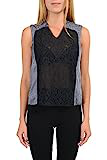

Recommended:  women's wing printing racerback vest top


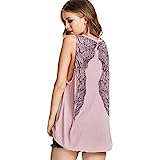

Recommended:  ducks row women's cap sleeve crop tee black


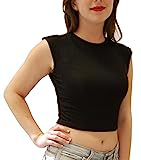

Recommended:  looney tunes size matters shirt size xl


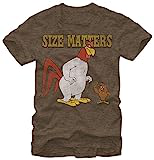


Query Title--> rag bone womens jean high low tunic xxs black


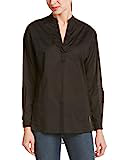

Recommended:  lacoste women's women's navy cotton polo size 40 l blue


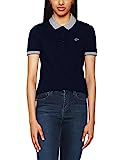

Recommended:  bella luxx women's woven cami extra small titanium


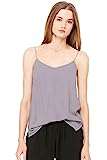

Recommended:  felina 2 pack women's medium long sleeve rib knit henley tees navy gray


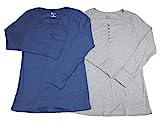


Query Title--> wayf womens large cutout drape back hi lo tank top


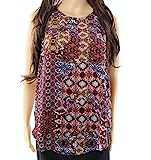

Recommended:  exotic india jet black jacket kashmir ari hand embroidered flowers


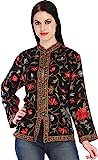

Recommended:  wotefusi women loose vintage punk style skull open back tassel tank top vest


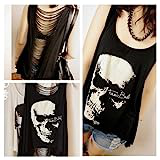

Recommended:  icocopro blouse space cotton stripe stitching dress shirt loose lotus leaf hem long sleeve one size


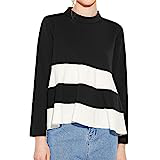


Query Title--> red women's dickey collar usa based igotcollared aka dicky collar detachable fake blouse collar


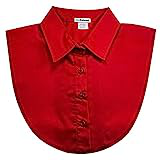

Recommended:  cruel women's long sleeve printed plain weave button down


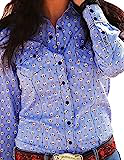

Recommended:  women's summer pastel candy colored tops tees lavender


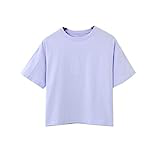

Recommended:  ro de womens medium pleated button blouse purple m


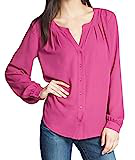

In [43]:
from PIL import Image
import requests

#Apparel Recommendation
for idx in random.sample(list(np.arange(len(df))), 4):
  print('Query Title-->', df['title'][idx]) #idx is the index of the query title
  im = Image.open(requests.get(df['medium_image_url'][idx], stream=True).raw)
  im.show()
  for j in closestkrecom(idx,3): #here, j provides the indices of 5 closest recommendations of title stored in df['title'][idx]
    print('Recommended: ',df['title'][j])
    im = Image.open(requests.get(df['medium_image_url'][j], stream=True).raw)
    im.show()
  print()